In [6]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp
from scipy.stats import ttest_rel, wilcoxon

warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, dummy_data=False)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False)
    new_dict['area_is_main']= fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False)
    combined_dict[mouse] = new_dict

In [8]:
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main']
all_mice = {}
for i, key in enumerate(analysis_names):
    # common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    # all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns]], ignore_index=False)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns], combined_dict['FIAA55.4d'][key][common_columns]], ignore_index=False)
    

In [9]:
key='homogenous_across_cubelet'
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
vis_proj = all_mice[key][all_mice[key][vis_adj].astype(bool).sum(axis=1)>0]
data = vis_proj[vis_adj].astype(bool).sum(axis=1).value_counts()

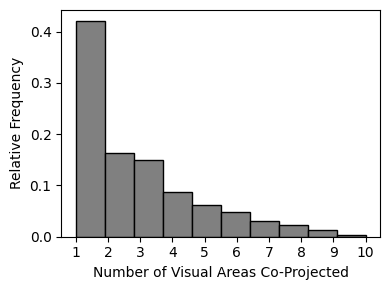

In [10]:
data = vis_proj[vis_adj].astype(bool).sum(axis=1)
fig, ax = plt.subplots(figsize=(4, 3))  
ax.hist(data, bins=10, weights=np.ones_like(data) / len(data), color='grey',edgecolor='black')
ax.set_xticks(np.arange(min(data), max(data) + 1, 1))
ax.set_xlabel('Number of Visual Areas Co-Projected')
ax.set_ylabel('Relative Frequency')
plt.tight_layout()
plt.show()

In [20]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
structure_tree = mcc.get_structure_tree()
cond_freq_dict = {}
for i, key in enumerate(analysis_names):
    #analysis_dict = {}
    # common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    # all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns]], ignore_index=False)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col == 'Contra':
            common_cols_cortex.append(col)
        if col != 'Contra':
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    #visual_areas = ['VISpor',  'VISli', 'VISpl','VISal', 'VISl', 'VISrl', 'VISp', 'VISa', 'VISam', 'VISpm']
    vis_adj =[vis for vis in visual_areas if vis in common_cols_cortex]
    cond_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
    for mouse in mice:
        for area in vis_adj:
            df = combined_dict[mouse][key][vis_adj]
            BC_cond =  df[df[area]>0].astype(bool).sum(axis=1).mean()
            cond_freq_df.loc[mouse][area] = BC_cond
    cond_freq_dict[key] = cond_freq_df

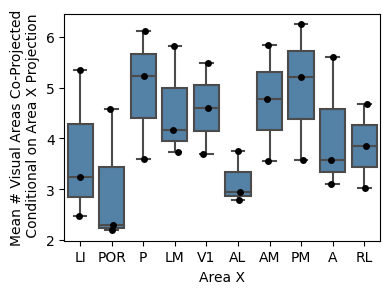

In [21]:
key='homogenous_across_cubelet'
to_look = cond_freq_dict[key]
to_look =fpf.convert_matrix_names(to_look)
df_long = to_look.reset_index().melt(id_vars='index', var_name='Area', value_name='BC_cond')
plt.figure(figsize=(4, 3))  

# Create the box plot
sb.boxplot(x='Area', y='BC_cond', data=df_long, color='steelblue', boxprops=dict(alpha=1))

# Overlay the individual data points with jitter
sb.stripplot(x='Area', y='BC_cond', data=df_long, jitter=True, color='black', size=5)

# Add labels
plt.xlabel('Area X')
plt.ylabel('Mean # Visual Areas Co-Projected\n Conditional on Area X Projection')


# Show the plot
#plt.xticks(rotation=90)  # Rotate x-ticks if area names are long
plt.tight_layout()  # Adjust layout
plt.show()

In [14]:
#with an increased threshold
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(resolution=25)
rsp = mcc.get_reference_space()
structure_tree = mcc.get_structure_tree()
cond_freq_dict = {}
key = 'homogenous_across_cubelet' #homog across area resets the index, therefore need to adjust code if you want to use
    #analysis_dict = {}
    # common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
# all_mice[key] = pd.concat([combined_dict['FIAA45.6a'][key][common_columns], combined_dict['FIAA45.6d'][key][common_columns]], ignore_index=False)
common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
set(combined_dict['FIAA55.4d'][key].columns)
)
common_cols_cortex = []
for col in common_columns:
    if col == 'Contra':
        common_cols_cortex.append(col)
    if col != 'Contra':
        structure = structure_tree.get_structures_by_acronym([col])
        if 315 in structure[0]['structure_id_path']:
            common_cols_cortex.append(col)
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
#visual_areas = ['VISpor',  'VISli', 'VISpl','VISal', 'VISl', 'VISrl', 'VISp', 'VISa', 'VISam', 'VISpm']
vis_adj =[vis for vis in visual_areas if vis in common_cols_cortex]
for threshold in np.arange(0.1, 1, 0.1):
    cond_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
    for mouse in mice:
        for area in vis_adj:
            df = combined_dict[mouse][key][vis_adj].copy(deep=True)
            parameters_path = (
            f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
            barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
            bcs_with_high_thresh = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, dummy_data=False, area_threshold=threshold)
            if area in bcs_with_high_thresh.columns:
                filtered_list = bcs_with_high_thresh[bcs_with_high_thresh[area]>0].index.to_list()
                BC_cond =  df.loc[filtered_list].astype(bool).sum(axis=1).mean()
                cond_freq_df.loc[mouse][area] = BC_cond
        cond_freq_dict[threshold] = cond_freq_df



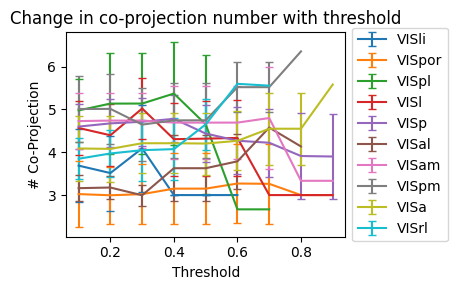

In [15]:

plt.figure(figsize=(6, 3))

# Assume cond_freq_dict is your dictionary where keys are thresholds, and values are DataFrames
first_key = next(iter(cond_freq_dict))  # Get the first DataFrame to retrieve columns
columns = cond_freq_dict[first_key].columns

# Prepare lists to store threshold and error bar values for each column
thresholds = list(cond_freq_dict.keys())

# Iterate over each column
for column in columns:
    means = []
    sems = []

    # Iterate through each threshold and calculate the mean and SEM for each column
    for threshold in thresholds:
        df = cond_freq_dict[threshold]
        n_replicates = df.shape[0]  # Number of replicates (rows)
        means.append(df[column].mean())  # Mean across replicates
        sem = df[column].std() / np.sqrt(n_replicates)  # Standard Error of the Mean (SEM)
        sems.append(sem)

    # Plot the line with error bars (SEM) for each column
    plt.errorbar(thresholds, means, yerr=sems, label=column, capsize=3)

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('# Co-Projection')
plt.title('Change in co-projection number with threshold')

# Place the legend outside the plot (right-hand side)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to avoid clipping
plt.tight_layout(rect=[0, 0, 0.75, 1])  # Make room for the legend outside

# Display the plot
plt.show()


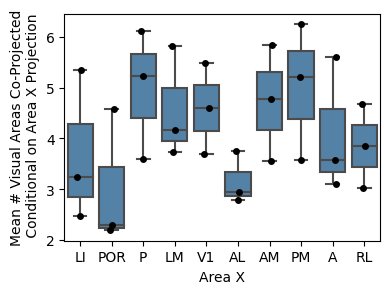

In [22]:
key='homogenous_across_cubelet'
to_look = cond_freq_dict[key]
to_look =fpf.convert_matrix_names(to_look)
df_long = to_look.reset_index().melt(id_vars='index', var_name='Area', value_name='BC_cond')
plt.figure(figsize=(4, 3))  

# Create the box plot
sb.boxplot(x='Area', y='BC_cond', data=df_long, color='steelblue', boxprops=dict(alpha=1))

# Overlay the individual data points with jitter
sb.stripplot(x='Area', y='BC_cond', data=df_long, jitter=True, color='black', size=5)

# Add labels
plt.xlabel('Area X')
plt.ylabel('Mean # Visual Areas Co-Projected\n Conditional on Area X Projection')


# Show the plot
#plt.xticks(rotation=90)  # Rotate x-ticks if area names are long
plt.tight_layout()  # Adjust layout
plt.show()

In [24]:
melted_dfs = []

for threshold, df in cond_freq_dict.items():
    # Reset index and melt the DataFrame
    df_long = df.reset_index().melt(id_vars='index', var_name='Area', value_name='BC_cond')
    # Add the threshold as a column
    df_long['Threshold'] = threshold
    # Append to the list
    melted_dfs.append(df_long)
plt.figure(figsize=(8, 6))
sb.lineplot(data=melted_dfs, x='Threshold', y='BC_cond', hue='Mouse', marker='o')
plt.title('Conditional Number of Brain Areas Targeted vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Areas Targeted')
plt.legend(title='Mouse')
plt.show()


# Show the plot
#plt.xticks(rotation=90)  # Rotate x-ticks if area names are long
plt.tight_layout()  # Adjust layout
plt.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 800x600 with 0 Axes>

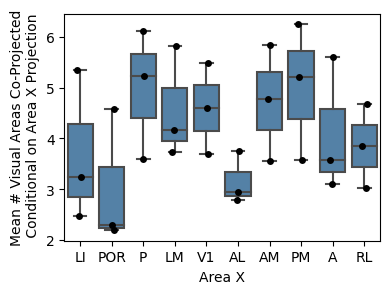

In [25]:
to_look = cond_freq_dict[key]
to_look =fpf.convert_matrix_names(to_look)
df_long = to_look.reset_index().melt(id_vars='index', var_name='Area', value_name='BC_cond')
plt.figure(figsize=(4, 3))  

# Create the box plot
sb.boxplot(x='Area', y='BC_cond', data=df_long, color='steelblue', boxprops=dict(alpha=1))

# Overlay the individual data points with jitter
sb.stripplot(x='Area', y='BC_cond', data=df_long, jitter=True, color='black', size=5)

# Add labels
plt.xlabel('Area X')
plt.ylabel('Mean # Visual Areas Co-Projected\n Conditional on Area X Projection')


plt.tight_layout()  # Adjust layout
plt.show()

In [ ]:
p_value

0.08096813861113933

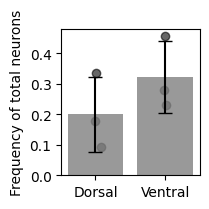

In [26]:
key = 'homogenous_across_cubelet'
dorsal_stream= ['AM', 'PM', 'RL', 'RL', 'A']
ventral_stream= ['P', 'LI', 'POR', 'LM']
which_proj = pd.DataFrame(index=mice, columns=['Dorsal', 'Ventral'])
for mouse in mice:
    to_look = combined_dict[mouse][key].copy(deep=True)
    to_look = fpf.convert_matrix_names(to_look)
    which_proj.loc[mouse]['Dorsal'] = len(to_look[to_look[dorsal_stream].sum(axis=1)>0])/len(to_look)
    which_proj.loc[mouse]['Ventral'] = len(to_look[to_look[ventral_stream].sum(axis=1)>0])/len(to_look)
    
means = which_proj.mean()  # Mean of each column
errors = which_proj.std()  # Standard deviation (you can replace this with SEM if desired)

# Step 2: Plot the bar chart with error bars
plt.figure(figsize=(2, 2))
plt.bar(x=means.index, height=means, yerr=errors, capsize=5, color='grey', alpha=0.8)
for i, col in enumerate(which_proj.columns):
    # Jittering to avoid overlap of data points
    x = np.random.normal(i, 0.04, size=len(which_proj[col]))  # Adds jitter to x-axis positions
    plt.scatter(x, which_proj[col], color='black', alpha=0.6, label='Individual Data' if i == 0 else "")

plt.tight_layout()
plt.ylabel('Frequency of total neurons')
plt.show()



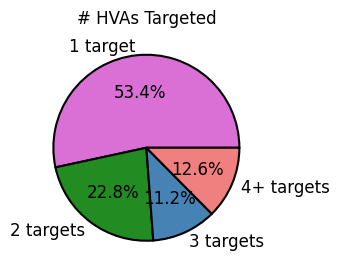

In [29]:
vis_proj = all_mice[key][all_mice[key][vis_adj].astype(bool).sum(axis=1)>0]
data = vis_proj[vis_adj].astype(bool).sum(axis=1).value_counts()
data_grouped = data.copy() 
data_grouped["4+"] = data_grouped.loc[4:].sum()
data_grouped = data_grouped.loc[:3].append(pd.Series(data_grouped["4+"], index=["4+"])) 
custom_colors = ['orchid', 'forestgreen', 'steelblue', 'lightcoral', 'gold'] 
sizes = data_grouped.values
labels = data_grouped.index.astype(str)  
data_grouped.index = [f"{label} target" if label == 1 else f"{label} targets" for label in data_grouped.index]
# Create the pie chart
fig, ax = plt.subplots(figsize=(3,4))

plt.pie(
    data_grouped,
    labels=data_grouped.index,
    autopct='%1.1f%%',
    textprops={'fontsize': 12},
    colors=custom_colors,  # Set the custom colors
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Add black borders around each slice
)

plt.title('# HVAs Targeted')
plt.show()

In [ ]:
#neurons projecting to a smaller number of areas ---> do we see the same pattern if we only include cubelets for brain area conditioned on if those brain areas make up >70% of the cubelet
#conditional probability targeting
#number of areas targeted


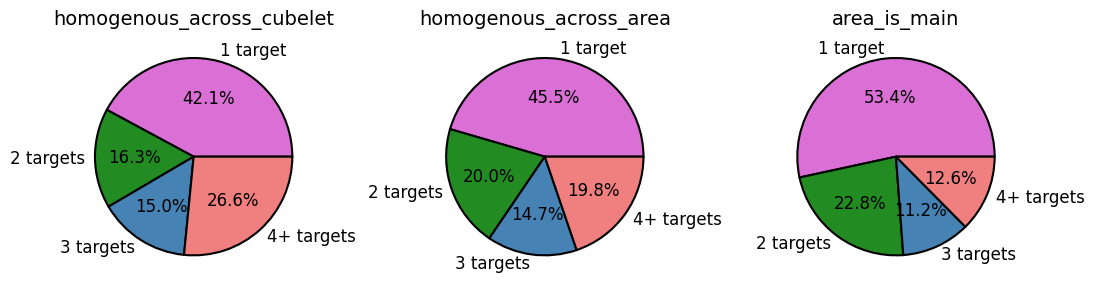

In [28]:
visual_areas = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']

fig, axes = plt.subplots(1, 3, figsize=(11, 3))
for ax, key in enumerate(analysis_names):
    vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
    vis_proj = all_mice[key][all_mice[key][vis_adj].astype(bool).sum(axis=1)>0]

    data = vis_proj[vis_adj].astype(bool).sum(axis=1).value_counts()
    data_grouped = data.copy() 
    data_grouped["4+"] = data_grouped.loc[4:].sum()
    data_grouped = data_grouped.loc[:3].append(pd.Series(data_grouped["4+"], index=["4+"])) 
    custom_colors = ['orchid', 'forestgreen', 'steelblue', 'lightcoral', 'gold'] 
    sizes = data_grouped.values
    labels = data_grouped.index.astype(str)  
    data_grouped.index = [f"{label} target" if label == 1 else f"{label} targets" for label in data_grouped.index]
    axes[ax].pie(
            data_grouped,
            labels=data_grouped.index,  # Use the formatted index as labels
            autopct='%1.1f%%',
            textprops={'fontsize': 12},
            colors=custom_colors,  # Set custom colors
            wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Add black borders
        )

        # Set the title for each subplot
    axes[ax].set_title(f'{key}', fontsize=14)

# Display the figure with all three pie charts
plt.tight_layout()

    #plt.title('Single neuron  is main approach')
plt.show()

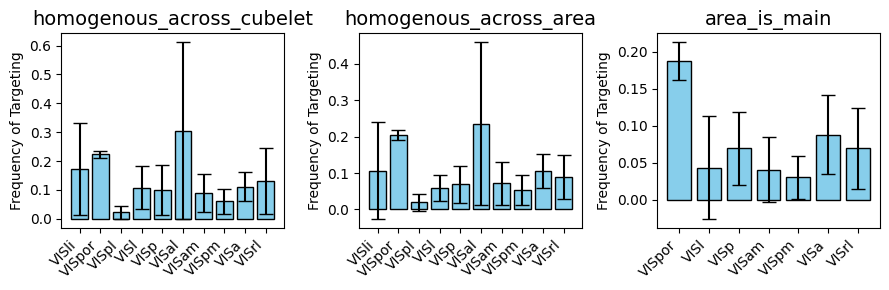

In [ ]:
#first take mean of each three mice
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
all_mice_freq={}
for ax, key in enumerate(analysis_names):
    vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
    freq_df = pd.DataFrame(columns=vis_adj, index=mice)
    for mouse in mice:
        freq_df.loc[mouse] = combined_dict[mouse][key][vis_adj].astype(bool).sum(axis=0)/len(combined_dict[mouse][key])
    all_mice_freq[key] = freq_df
    means = freq_df.mean()
    errors = freq_df.std()  
    axes[ax].bar(means.index, means, yerr=errors, capsize=5, color='skyblue', edgecolor='black')
    axes[ax].set_xticklabels(means.index, rotation=45, ha='right')
    axes[ax].set_title(f'{key}', fontsize=14)
    axes[ax].set_ylabel('Frequency of Targeting')

plt.tight_layout()
plt.show()

In [ ]:
key = 'area_is_main'
layers = ['upper', 'lower']
mouse_layer_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    parameters = ps.load_parameters(directory=parameters_path)
    sample_vol_and_regions = pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    sample_vol_and_regions['fractions'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
    sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
    AUDp_containing = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    AUDp_containing = [sample for sample in AUDp_containing if sample in barcodes.columns]
    for layer in layers:
        barcodes_new = barcodes[barcodes.idxmax(axis=1).isin(parameters[f'{layer}_layer'])].drop(columns=AUDp_containing)
        barcodes_new = barcodes_new[
    (barcodes_new[[f for f in parameters['cortical_samples'] if f in barcodes_new.columns]].astype(bool).sum(axis=1) > 0) &
    (barcodes_new[[s for s in parameters['tectum_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0) &
    (barcodes_new[[s for s in parameters['thalamus_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0)
]
        
        new_dict[f'{layer}_layer'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False)
        missing_cols = set(all_mice[key].columns) - set(new_dict[f'{layer}_layer'].columns)
        for col in missing_cols:
            new_dict[f'{layer}_layer'][col] = 0
    mouse_layer_dict[mouse] = new_dict
vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
upper_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
lower_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
for layer in layers:
    for mouse in mice:
        upper_freq_df.loc[mouse] = mouse_layer_dict[mouse]['upper_layer'][vis_adj].astype(bool).sum(axis=0)/len(mouse_layer_dict[mouse]['upper_layer'][mouse_layer_dict[mouse]['upper_layer'][vis_adj].astype(bool).sum(axis=1)>0])
        lower_freq_df.loc[mouse] = mouse_layer_dict[mouse]['lower_layer'][vis_adj].astype(bool).sum(axis=0)/len(mouse_layer_dict[mouse]['lower_layer'][mouse_layer_dict[mouse]['lower_layer'][vis_adj].astype(bool).sum(axis=1)>0])

In [30]:

layers = ['upper', 'lower']
mouse_layer_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    parameters = ps.load_parameters(directory=parameters_path)
    sample_vol_and_regions = pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    sample_vol_and_regions['fractions'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
    sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
    AUDp_containing = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    AUDp_containing = [sample for sample in AUDp_containing if sample in barcodes.columns]
    for layer in layers:
        area_dict = {}
        barcodes_new = barcodes[barcodes.idxmax(axis=1).isin(parameters[f'{layer}_layer'])].drop(columns=AUDp_containing)
        barcodes_new = barcodes_new[
            (barcodes_new[[f for f in parameters['cortical_samples'] if f in barcodes_new.columns]].astype(bool).sum(axis=1) > 0) &
            (barcodes_new[[s for s in parameters['tectum_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0) &
            (barcodes_new[[s for s in parameters['thalamus_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0)
        ]
        area_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False)
        missing_cols = set(all_mice[key].columns) - set(area_dict['area_is_main'].columns) #since there is some zero values for regions that are looked at
        for col in missing_cols:
            area_dict['area_is_main'][col] = 0
        area_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False, dummy_data=False)
        area_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False)
        new_dict[f'{layer}_layer'] = area_dict
        # print(f"Creating barcodes for {layer} layer in {mouse}")
        # print(area_dict['homogenous_across_area'])
    
    mouse_layer_dict[mouse] = new_dict
freq_dic = {}
ttest_dic = {}
for key in analysis_names:
    vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
    upper_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
    lower_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
    for mouse in mice:
        upper_freq_df.loc[mouse] = mouse_layer_dict[mouse]['upper_layer'][key][vis_adj].astype(bool).sum(axis=0)/len(mouse_layer_dict[mouse]['upper_layer'][key][mouse_layer_dict[mouse]['upper_layer'][key][vis_adj].astype(bool).sum(axis=1)>0])
        lower_freq_df.loc[mouse] = mouse_layer_dict[mouse]['lower_layer'][key][vis_adj].astype(bool).sum(axis=0)/len(mouse_layer_dict[mouse]['lower_layer'][key][mouse_layer_dict[mouse]['lower_layer'][key][vis_adj].astype(bool).sum(axis=1)>0])
    new_dict_add = {}
    new_dict_add['upper'] = fpf.convert_matrix_names(upper_freq_df)
    new_dict_add['lower'] = fpf.convert_matrix_names(lower_freq_df)
    freq_dic[key] = new_dict_add
    results = pd.DataFrame(index=upper_freq_df.columns, columns=['t_statistic', 't_p_value', 'wilcoxon_stat', 'wilcoxon_p_value'])

    for col in upper_freq_df.columns:
        upper_values = upper_freq_df[col]
        lower_values = lower_freq_df[col]
        t_stat, t_p_value = ttest_rel(upper_values, lower_values)
        try:
            wilcoxon_stat, wilcoxon_p_value = wilcoxon(upper_values, lower_values)
        except ValueError:
            wilcoxon_stat, wilcoxon_p_value = None, None  
        results.loc[col] = [t_stat, t_p_value, wilcoxon_stat, wilcoxon_p_value]
    ttest_dic[key] = results

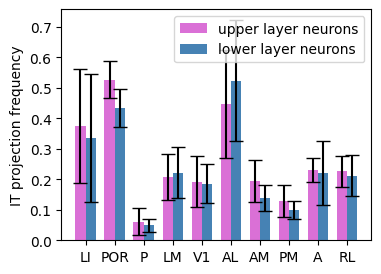

In [32]:
fig, axes = plt.subplots(1, figsize=(4, 3))
key = 'homogenous_across_cubelet'
#for ax, key in enumerate(analysis_names):
upper_means = freq_dic[key]['upper'].mean()
upper_stds = freq_dic[key]['upper'].std()
lower_means = freq_dic[key]['lower'].mean()
lower_stds = freq_dic[key]['lower'].std()
upper_se = freq_dic[key]['upper'].std(axis=0) / np.sqrt(len(mice))
lower_se = freq_dic[key]['lower'].std(axis=0) / np.sqrt(len(mice))
bar_width = 0.35  # Width of the bars
indices = np.arange(len(upper_means))  # x locations for the groups

axes.bar(indices - bar_width / 2, upper_means, bar_width, yerr=upper_se, label='upper layer neurons', color='orchid', capsize=5)
axes.bar(indices + bar_width / 2, lower_means, bar_width, yerr=lower_se, label='lower layer neurons', color='steelblue', capsize=5)
axes.set_ylabel('IT projection frequency', fontsize=10)
#axes.set_title(f'{key}', fontsize=16)
axes.set_xticks(indices)  # Set the x locations for the tick marks
axes.set_xticklabels(upper_means.index, rotation=0, ha='center')  # Use column names as labels
axes.legend()

# plt.tight_layout()
plt.show()


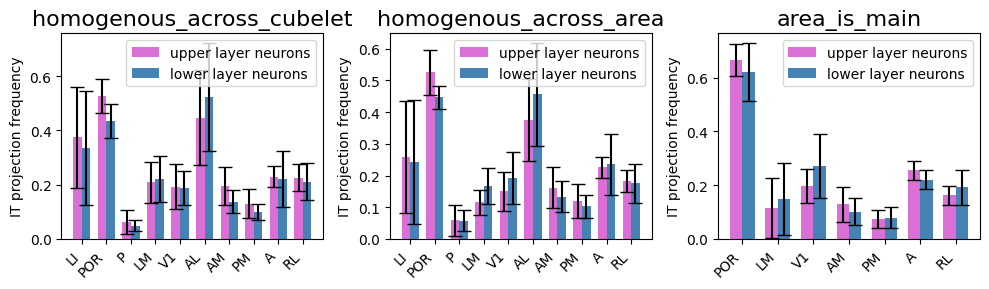

In [33]:

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, key in enumerate(analysis_names):
    upper_means = freq_dic[key]['upper'].mean()
    upper_stds = freq_dic[key]['upper'].std()
    lower_means = freq_dic[key]['lower'].mean()
    lower_stds = freq_dic[key]['lower'].std()
    upper_se = freq_dic[key]['upper'].std(axis=0) / np.sqrt(len(mice))
    lower_se = freq_dic[key]['lower'].std(axis=0) / np.sqrt(len(mice))
    bar_width = 0.35  # Width of the bars
    indices = np.arange(len(upper_means))  # x locations for the groups

    axes[ax].bar(indices - bar_width / 2, upper_means, bar_width, yerr=upper_se, label='upper layer neurons', color='orchid', capsize=5)
    axes[ax].bar(indices + bar_width / 2, lower_means, bar_width, yerr=lower_se, label='lower layer neurons', color='steelblue', capsize=5)
    axes[ax].set_ylabel('IT projection frequency', fontsize=10)
    axes[ax].set_title(f'{key}', fontsize=16)
    axes[ax].set_xticks(indices)  # Set the x locations for the tick marks
    axes[ax].set_xticklabels(upper_means.index, rotation=45, ha='right')  # Use column names as labels
    axes[ax].legend()

plt.tight_layout()
plt.show()


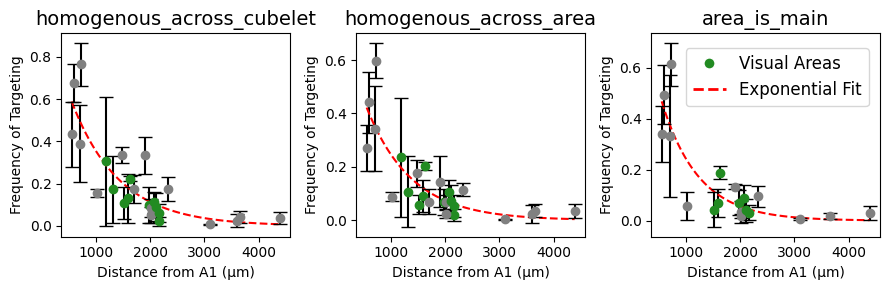

In [34]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()
a1_dist_dict = {}
# Get the structure ID and coordinates for AUDp (A1 region)
structure = structure_tree.get_structures_by_acronym(['AUDp'])
structure_id = structure[0]['id']
mask = rsp.make_structure_mask([structure_id], direct_only=False)
A1_coord = (np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2]))

# Prepare subplots
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

# Create custom legend elements for visual areas and exponential fit
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Visual Areas',
                          markerfacecolor='forestgreen', markersize=8, linestyle='None'),
                   Line2D([0], [0], color='red', lw=2, linestyle='--', label='Exponential Fit')]

# Exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)  # Ensure numpy array for compatibility

# Main loop for plotting
for ax, key in enumerate(analysis_names):
    # Get all areas except 'Contra'
    areas = all_mice[key].columns
    to_drop = ['Contra', 'AUDp']
    to_drop = [drop for drop in to_drop if drop in areas]
    areas = areas.drop(to_drop)
    vis_adj = [vis for vis in visual_areas if vis in all_mice[key].columns]

    # Calculate distances from A1 for each area
    distance_from_a1 = pd.DataFrame(index=areas, columns=['dist'])
    for col in areas:
        structure = structure_tree.get_structures_by_acronym([col])
        structure_id = structure[0]['id']
        mask = rsp.make_structure_mask([structure_id], direct_only=False)
        vis_coord = np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2])
        distance_from_a1.loc[col] = np.linalg.norm(np.array(A1_coord) - np.array(vis_coord)) * 25

    # Store distances in the dictionary
    a1_dist_dict[key] = distance_from_a1

    # Create frequency DataFrame for the current key
    freq_df = pd.DataFrame(columns=areas, index=mice)
    for mouse in mice:
        freq_df.loc[mouse] = combined_dict[mouse][key][areas].astype(bool).sum(axis=0) / len(combined_dict[mouse][key])

    # Convert distances and means to pandas Series for easier access
    if isinstance(a1_dist_dict[key], pd.DataFrame):
        distances = pd.Series(a1_dist_dict[key].iloc[:, 0], index=areas)
    else:
        distances = pd.Series(a1_dist_dict[key], index=areas)
    # Ensure distances and means are numeric
    distances = pd.to_numeric(distances, errors='coerce')
    means = pd.to_numeric(freq_df.mean(), errors='coerce')
    errors = pd.to_numeric(freq_df.std(), errors='coerce')

    # Reindex means and errors to match areas
    means = pd.Series(means, index=areas)
    errors = pd.Series(errors, index=areas)

    # Fit the exponential decay curve to the mean values vs. distance
    if len(distances) > 1 and (means > 0).any() and not distances.isnull().any() and not means.isnull().any():
        try:
            # Fit the exponential decay curve
            params, _ = curve_fit(exponential_decay, distances.values, means.values, p0=(max(means), 0.001))

            # Generate a smooth curve for plotting
            fitted_x = np.linspace(min(distances), max(distances), 100)
            fitted_y = exponential_decay(fitted_x, *params)

            # Plot the fitted exponential decay curve
            axes[ax].plot(fitted_x, fitted_y, color='red', linestyle='--', label=f'Exponential Fit: $y = {params[0]:.2f}e^{{-{params[1]:.4f}x}}$')

        except Exception as e:
            print(f"Error fitting exponential curve for key {key}: {e}")

    # Plot each data point individually with its corresponding color
    for area in areas:
        color = 'forestgreen' if area in vis_adj else 'gray'  # Forest green for vis_adj areas, gray otherwise
        axes[ax].errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black',
                          mfc=color, mec=color, capsize=5)

    # Customize plot appearance
    axes[ax].set_title(f'{key}', fontsize=14)
    axes[ax].set_ylabel('Frequency of Targeting')
    axes[ax].set_xlabel('Distance from A1 (µm)')

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.85), fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


KS Statistic: 0.16, p-value: 0.914993219397903


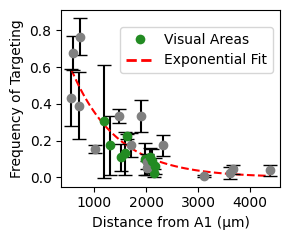

In [35]:
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()

# Get the structure ID and coordinates for AUDp (A1 region)
structure = structure_tree.get_structures_by_acronym(['AUDp'])
structure_id = structure[0]['id']
mask = rsp.make_structure_mask([structure_id], direct_only=False)
A1_coord = (np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2]))

# Prepare subplots
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))  # Use a single plot for key[2]

# Create custom legend elements for visual areas and exponential fit
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Visual Areas',
                          markerfacecolor='forestgreen', markersize=8, linestyle='None'),
                   Line2D([0], [0], color='red', lw=2, linestyle='--', label='Exponential Fit')]

# Exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Main loop for plotting - only for `key[2]`
key_to_plot = analysis_names[0]  # Use key[2] to select the key of interest

# Get all areas except 'Contra' for key[2]
areas = all_mice[key_to_plot].columns
areas = areas.drop(['Contra', 'AUDp'])
vis_adj = [vis for vis in visual_areas if vis in all_mice[key_to_plot].columns]

# Calculate distances from A1 for each area
distance_from_a1 = pd.DataFrame(index=areas, columns=['dist'])
for col in areas:
    structure = structure_tree.get_structures_by_acronym([col])
    structure_id = structure[0]['id']
    mask = rsp.make_structure_mask([structure_id], direct_only=False)
    vis_coord = np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2])
    distance_from_a1.loc[col] = np.linalg.norm(np.array(A1_coord) - np.array(vis_coord)) * 25

# Store distances for key[2]
a1_dist_dict[key_to_plot] = distance_from_a1

# Create frequency DataFrame for the current key[2]
freq_df = pd.DataFrame(columns=areas, index=mice)
for mouse in mice:
    freq_df.loc[mouse] = combined_dict[mouse][key_to_plot][areas].astype(bool).sum(axis=0) / len(combined_dict[mouse][key_to_plot])

# Convert distances and means to pandas Series for easier access
if isinstance(a1_dist_dict[key_to_plot], pd.DataFrame):
    distances = pd.Series(a1_dist_dict[key_to_plot].iloc[:, 0], index=areas)
else:
    distances = pd.Series(a1_dist_dict[key_to_plot], index=areas)

# Ensure distances and means are numeric
distances = pd.to_numeric(distances, errors='coerce')
means = pd.to_numeric(freq_df.mean(), errors='coerce')
errors = pd.to_numeric(freq_df.std(), errors='coerce')

# Reindex means and errors to match areas
means = pd.Series(means, index=areas)
errors = pd.Series(errors, index=areas)

# Fit the exponential decay curve to the mean values vs. distance
if len(distances) > 1 and (means > 0).any() and not distances.isnull().any() and not means.isnull().any():
    try:
        # Fit the exponential decay curve
        params, _ = curve_fit(exponential_decay, distances.values, means.values, p0=(max(means), 0.001))

        # Generate a smooth curve for plotting
        fitted_x = np.linspace(min(distances), max(distances), 100)
        fitted_y = exponential_decay(fitted_x, *params)

        # Plot the fitted exponential decay curve
        ax.plot(fitted_x, fitted_y, color='red', linestyle='--',
                label=f'Exponential Fit: $y = {params[0]:.2f}e^{{-{params[1]:.4f}x}}$')

        # Kolmogorov-Smirnov test (KS test) for goodness-of-fit
        fitted_values = exponential_decay(distances.values, *params)  # Fitted values at the empirical data points
        ks_stat, ks_p_value = ks_2samp(means.values, fitted_values)
        print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}")
        # ax.text(0.05, 0.95, f'KS p-value: {ks_p_value:.4f}', transform=ax.transAxes, fontsize=10,
        #         verticalalignment='top')

    except Exception as e:
        print(f"Error fitting exponential curve for key {key_to_plot}: {e}")

# Plot each data point individually with its corresponding color
for area in areas:
    color = 'forestgreen' if area in vis_adj else 'gray'  # Forest green for vis_adj areas, gray otherwise
    ax.errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black',
                mfc=color, mec=color, capsize=5)

# Customize plot appearance
ax.set_ylabel('Frequency of Targeting')
ax.set_xlabel('Distance from A1 (µm)')

# Create a legend for the entire plot
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.9), fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


KS Statistic: 0.2, p-value: 0.7102038997076623


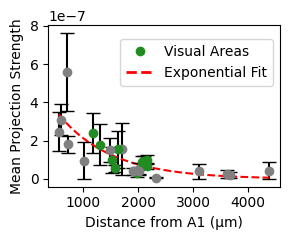

In [36]:
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
rsp = mcc.get_reference_space()

# Get the structure ID and coordinates for AUDp (A1 region)
structure = structure_tree.get_structures_by_acronym(['AUDp'])
structure_id = structure[0]['id']
mask = rsp.make_structure_mask([structure_id], direct_only=False)
A1_coord = (np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2]))

# Prepare subplots
fig, ax = plt.subplots(1, 1, figsize=(3,2.5))  # Use a single plot for key[2]

# Create custom legend elements for visual areas and exponential fit
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Visual Areas',
                          markerfacecolor='forestgreen', markersize=8, linestyle='None'),
                   Line2D([0], [0], color='red', lw=2, linestyle='--', label='Exponential Fit')]

# Exponential decay function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Main loop for plotting - only for `key[2]`
key_to_plot = analysis_names[0]  # Use key[2] to select the key of interest

# Get all areas except 'Contra' for key[2]
areas = all_mice[key_to_plot].columns
areas = areas.drop(['Contra', 'AUDp'])
vis_adj = [vis for vis in visual_areas if vis in all_mice[key_to_plot].columns]

# Calculate distances from A1 for each area
distance_from_a1 = pd.DataFrame(index=areas, columns=['dist'])
for col in areas:
    structure = structure_tree.get_structures_by_acronym([col])
    structure_id = structure[0]['id']
    mask = rsp.make_structure_mask([structure_id], direct_only=False)
    vis_coord = np.mean(np.where(mask == 1)[0]), np.mean(np.where(mask == 1)[1]), np.mean(np.where(mask == 1)[2])
    distance_from_a1.loc[col] = np.linalg.norm(np.array(A1_coord) - np.array(vis_coord)) * 25

# Store distances for key[2]
a1_dist_dict[key_to_plot] = distance_from_a1

# Create frequency DataFrame for the current key[2]
freq_df = pd.DataFrame(columns=areas, index=mice)
for mouse in mice:
    freq_df.loc[mouse] = combined_dict[mouse][key_to_plot][areas].replace(0, np.nan).mean(axis=0)

# Convert distances and means to pandas Series for easier access
if isinstance(a1_dist_dict[key_to_plot], pd.DataFrame):
    distances = pd.Series(a1_dist_dict[key_to_plot].iloc[:, 0], index=areas)
else:
    distances = pd.Series(a1_dist_dict[key_to_plot], index=areas)

# Ensure distances and means are numeric
distances = pd.to_numeric(distances, errors='coerce')
means = pd.to_numeric(freq_df.mean(), errors='coerce')
errors = pd.to_numeric(freq_df.std(), errors='coerce')

# Reindex means and errors to match areas
means = pd.Series(means, index=areas)
errors = pd.Series(errors, index=areas)

# Fit the exponential decay curve to the mean values vs. distance
if len(distances) > 1 and (means > 0).any() and not distances.isnull().any() and not means.isnull().any():
    try:
        # Fit the exponential decay curve
        params, _ = curve_fit(exponential_decay, distances.values, means.values, p0=(max(means), 0.001))

        # Generate a smooth curve for plotting
        fitted_x = np.linspace(min(distances), max(distances), 100)
        fitted_y = exponential_decay(fitted_x, *params)

        # Plot the fitted exponential decay curve
        ax.plot(fitted_x, fitted_y, color='red', linestyle='--',
                label=f'Exponential Fit: $y = {params[0]:.2f}e^{{-{params[1]:.4f}x}}$')

    except Exception as e:
        print(f"Error fitting exponential curve for key {key_to_plot}: {e}")

# Plot each data point individually with its corresponding color
for area in areas:
    color = 'forestgreen' if area in vis_adj else 'gray'  # Forest green for vis_adj areas, gray otherwise
    ax.errorbar(distances[area], means[area], yerr=errors[area], fmt='o', ecolor='black',
                mfc=color, mec=color, capsize=5)

# Customize plot appearance
#ax.set_title(f'{key_to_plot}', fontsize=14)
ax.set_ylabel('Mean Projection Strength')
ax.set_xlabel('Distance from A1 (µm)')
fitted_values = exponential_decay(distances.values, *params) 
ks_stat, ks_p_value = ks_2samp(means.values, fitted_values)
print(f"KS Statistic: {ks_stat}, p-value: {ks_p_value}")
# Create a legend for the entire plot
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.95, 0.85), fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [37]:

layers = ['upper', 'lower']
mouse_layer_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded_with_source.pkl")
    parameters = ps.load_parameters(directory=parameters_path)
    sample_vol_and_regions = pd.read_pickle(pathlib.Path(parameters['lcm_directory'])/'sample_vol_and_regions.pkl')
    sample_vol_and_regions['fractions'] = sample_vol_and_regions['breakdown'].apply(ast.literal_eval)
    sample_vol_and_regions['regions'] = sample_vol_and_regions['regions'].apply(ast.literal_eval)
    AUDp_containing = sample_vol_and_regions[sample_vol_and_regions['main']=='AUDp']['ROI Number'].to_list()
    AUDp_containing = [sample for sample in AUDp_containing if sample in barcodes.columns]
    for layer in layers:
        area_dict = {}
        barcodes_new = barcodes[barcodes.idxmax(axis=1).isin(parameters[f'{layer}_layer'])].drop(columns=AUDp_containing)
        barcodes_new = barcodes_new[
            (barcodes_new[[f for f in parameters['cortical_samples'] if f in barcodes_new.columns]].astype(bool).sum(axis=1) > 0) &
            (barcodes_new[[s for s in parameters['tectum_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0) &
            (barcodes_new[[s for s in parameters['thalamus_samples'] if s in barcodes_new.columns]].astype(bool).sum(axis=1) == 0)
        ]
        area_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False)
        missing_cols = set(all_mice[key].columns) - set(area_dict['area_is_main'].columns) #since there is some zero values for regions that are looked at
        for col in missing_cols:
            area_dict['area_is_main'][col] = 0
        area_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False, dummy_data=False)
        area_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes_new, cortical=True, shuffled=False)
        new_dict[f'{layer}_layer'] = area_dict
        # print(f"Creating barcodes for {layer} layer in {mouse}")
        # print(area_dict['homogenous_across_area'])
    
    mouse_layer_dict[mouse] = new_dict
freq_dic = {}
ttest_dic = {}
for key in analysis_names:
    vis_adj =[vis for vis in visual_areas if vis in all_mice[key].columns]
    upper_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
    lower_freq_df = pd.DataFrame(columns=vis_adj, index=mice)
    for mouse in mice:
        upper_freq_df.loc[mouse] = mouse_layer_dict[mouse]['upper_layer'][key][vis_adj].replace(0, np.nan).mean(axis=0)
        lower_freq_df.loc[mouse] = mouse_layer_dict[mouse]['lower_layer'][key][vis_adj].replace(0, np.nan).mean(axis=0)
    new_dict_add = {}
    new_dict_add['upper'] = upper_freq_df
    new_dict_add['lower'] = lower_freq_df
    freq_dic[key] = new_dict_add
    results = pd.DataFrame(index=upper_freq_df.columns, columns=['t_statistic', 't_p_value', 'wilcoxon_stat', 'wilcoxon_p_value'])

    for col in upper_freq_df.columns:
        upper_values = upper_freq_df[col]
        lower_values = lower_freq_df[col]
        t_stat, t_p_value = ttest_rel(upper_values, lower_values)
        try:
            wilcoxon_stat, wilcoxon_p_value = wilcoxon(upper_values, lower_values)
        except ValueError:
            wilcoxon_stat, wilcoxon_p_value = None, None  
        results.loc[col] = [t_stat, t_p_value, wilcoxon_stat, wilcoxon_p_value]
    ttest_dic[key] = results

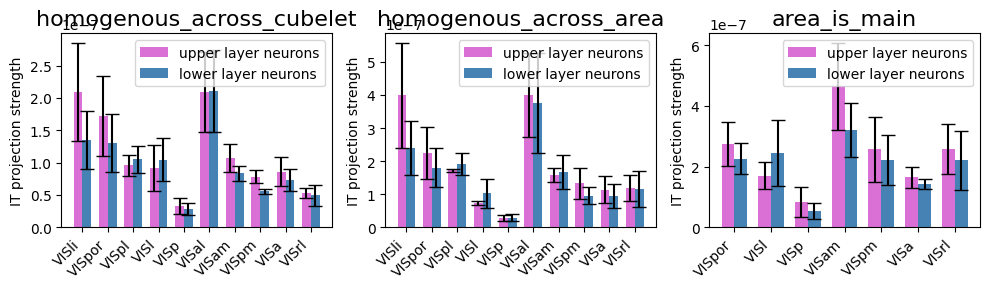

In [38]:

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for ax, key in enumerate(analysis_names):
    upper_means = freq_dic[key]['upper'].mean()
    upper_stds = freq_dic[key]['upper'].std()
    lower_means = freq_dic[key]['lower'].mean()
    lower_stds = freq_dic[key]['lower'].std()
    upper_se = freq_dic[key]['upper'].std(axis=0) / np.sqrt(len(mice))
    lower_se = freq_dic[key]['lower'].std(axis=0) / np.sqrt(len(mice))
    bar_width = 0.35  # Width of the bars
    indices = np.arange(len(upper_means))  # x locations for the groups

    axes[ax].bar(indices - bar_width / 2, upper_means, bar_width, yerr=upper_se, label='upper layer neurons', color='orchid', capsize=5)
    axes[ax].bar(indices + bar_width / 2, lower_means, bar_width, yerr=lower_se, label='lower layer neurons', color='steelblue', capsize=5)
    axes[ax].set_ylabel('IT projection strength', fontsize=10)
    axes[ax].set_title(f'{key}', fontsize=16)
    axes[ax].set_xticks(indices)  # Set the x locations for the tick marks
    axes[ax].set_xticklabels(upper_means.index, rotation=45, ha='right')  # Use column names as labels
    axes[ax].legend()

plt.tight_layout()
plt.show()


In [ ]:
ttest_dic['homogenous_across_cubelet']

,t_statistic,t_p_value,wilcoxon_stat,wilcoxon_p_value
VISli,2.341962,0.143968,0.0,0.25
VISpor,2.006976,0.182557,0.0,0.25
VISpl,-0.541626,0.642346,2.0,0.75
VISl,-1.17206,0.361891,1.0,0.5
VISp,0.85496,0.482645,1.0,0.5
VISal,-0.054265,0.961657,3.0,1.0
VISam,1.409461,0.294084,0.0,0.25
VISpm,3.745383,0.064469,0.0,0.25
VISa,2.088346,0.171994,0.0,0.25
VISrl,0.363213,0.751243,2.0,0.75


In [ ]:
annotation 

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [ ]:
(x, y, z) = np.mean(np.where(mask==1)[0]), np.mean(np.where(mask==1)[1]), np.mean(np.where(mask==1)[2])

In [ ]:
mask = rsp.make_structure_mask([structure_id], direct_only=False)

In [ ]:
z

227.66457460721418

([<matplotlib.patches.Wedge at 0x7f85ac6e0460>,
 [Text(-0.31177921092958094, 1.0548903846524187, ''),
  Text(-0.25843101463158485, -1.0692115836804659, ''),
  Text(0.8547961089041499, -0.6923320100951024, ''),
  Text(1.0796791173174471, -0.2104590307604272, ''),
  Text(1.099160948631608, -0.04295589602445277, ''),
  Text(1.0999957183268307, -0.0030691468911576234, '')])

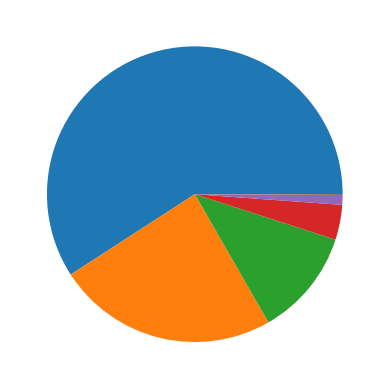

In [ ]:
plt.pie(vis_proj[vis_adj].astype(bool).sum(axis=1).value_counts())